In [201]:
%%html
<style>
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
}
.prompt 
    display:none;
}  
</style>

## Description of the problem

Chloropleth maps can be an efficient way to represent geographical variation in an outcome of interest. However, they can also be quite misleading if the construction of color classes is not well thought out. Worse, by carefully handpicking color classes, one can make a map carry very different messages. Hence strong guidelines are needed in order to build meaningful maps, and several questions arise in practice: how many color classes should be chosen? How should these classes be constructed? How should we proceed when we want to compare chloropleth maps for several outcomes (or for the same outcome over time)?
Choosing color classes is basically a clustering problem, so the methods and tools available have their origin in cluster analysis. There is a nice python library called `mapclassify` that provides a number of very useful methods, but I will present other possible approaches as well.

## TL;DR
* Fisher-Jenks' exact optimization method provides a way to find a classification acheiving maximum between-class variance for a given number of classes. It is certainly (one of) the best methods out there.
* When comparing maps, the number of color classes should be chosen endogenously for a fair comparison. This can be done by setting a between-class variance threshold and picking the minimum number of classes required to reach the threshold, separately for each map.

## Data

I will be using wage data from France, at the *département* level (similar to a US county). The data is available from the [Insee website](https://www.insee.fr/fr/statistiques/2012748) and provides the yearly net wage by gender and occupation category.
I will also make use of the GIS data for French administrative boundaries available from [GADM](https://gadm.org/download_country_v3.html).

In [202]:
import pandas as pd
import geopandas as gpd

# Wage data
url_wage = 'https://www.insee.fr/fr/statistiques/fichier/2012748/TCRD_049.xls'
data_wage = pd.read_excel(url_wage, skiprows=3, nrows=96)
cols_wage = ['dep_code', 'dep_name', 'all', 'men', 'women', 'managers', 'professionals', 'clerks', 'workers']
data_wage.rename(columns=dict(zip(data_wage.columns, cols_wage)), inplace=True)

# Geographical data
url_geo = "zip+https://biogeo.ucdavis.edu/data/gadm3.6/shp/gadm36_FRA_shp.zip"
data_geo = gpd.read_file(url_geo, layer='gadm36_FRA_2').to_crs(epsg=2154)

# Merged data
data = data_geo.merge(data_wage, left_on='CC_2', right_on='dep_code', how='inner')

## An example

As an example, let's try to build a chloropleth map for the average net wage. The first thing that we might think of could be to break down the wage into equal-length bins. However, this might result in some classes having many counties while others are almost empty. We could solve this issue by computing the quantiles of the wage to get classes with the same number of counties. As it turns out `geopandas` provides a seamless interface with `mapclassify`, allowing us to test these two methods easily.

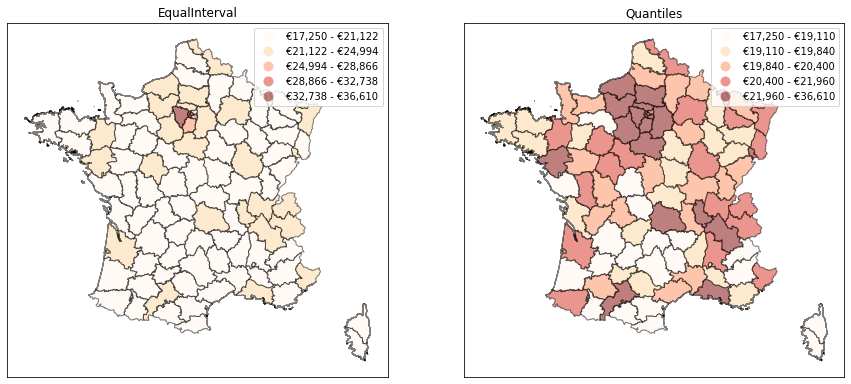

In [203]:
import matplotlib.pyplot as plt
schemes = ['EqualInterval', 'Quantiles']
fig, ax = plt.subplots(1, len(schemes), figsize=(15, 15))
        
def draw_map(column, ax, scheme, k=5, **kwargs):
    # Draw map
    data.plot(column=column,
              edgecolor='black',
              alpha=.5,
              cmap='OrRd',
              legend=True,
              ax=ax,
              k=k,
              scheme=scheme,
              **kwargs
             )
    # Clean plot
    leg = ax.get_legend()
    for l in leg.get_texts():
        t = l.get_text()
        b = t.split(' - ')
        l.set_text(' - '.join([f'€{float(x):,.0f}' for x in b]))
    ax.tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)
    
for (s, a) in zip(schemes, ax.flatten()):
    draw_map('all', a, s)
    a.set_title(s)
plt.show()

As we can see above, these two methods produce maps which carry completely different messages. When using equal-length bins, we get the impression that the country is basically divided in two: the Paris region concentrates high wages, while there is not much variation in the rest of the country. With quantiles, we get a much more nuanced view since we constrain the number of counties of each color to be the same. But most of the information actually moves to the legend: we see that the top class is much more heterogenous than all the others, with a range of about €15k (vs. about €1k for all other classes). Which map should we choose? In my view, they both fail to represent the true nature of the distribution of wages in France. The Paris region does have much higher average wages, which the quantiles map fails to capture. But using equal-length bins fails to represent the fact that other big cities also have higher wages than rural areas. Another issue is that some of the classes in that map are just empty.

## A clustering problem

Choosing color classes basically boils down to a clustering problem: we want to group regions that are "similar" in terms of the variable of interest (i.e. we want to create homogenous classes), and we want to create as many groups as necessary to capture "enough" of the dissimilarity between regions. The problem is to define what we mean by "similar regions" and "enough groups", but the tools from cluster analysis can help do that. 

A typical definition of a homogenous class is one with the lowest possible variance. With this definition, a possibility would be to build on the *k-means* algorithm to generate a partition with minimum within-class variance. However *k-means* is not guaranteed to find the optimal such partition, and the classes it creates are random as they depend on the initial centers, which may not be desirable. An alternative is to use the Fisher-Jenks method, a 1D variant of *k-means* which obtains the exact minimum variance classification.[<sup id="#ln1">1</sup>](#fn1)

The Fisher-Jenks method is available out of the box in `mapclassify`, and we can try it below. We obtain a much more balanced outlook on regional inequalities: the Paris region stands out, but so do the other major cities of Lyon and Toulouse (with the Airbus hub in Toulouse driving up wages in that region).

---

[<sup id="#fn1">1</sup>](#ln1) there seem to be several variations of this method (natural breaks, Jenks-Caspall, Max-P, etc.). My understanding is that these algorithms can speed-up computations when many observations are involved, but that Fisher-Jenks' exact optimization method will always dominate (also see [this book](https://geographicdata.science/book/notebooks/05_choropleth.html#Choropleth-mapping)).

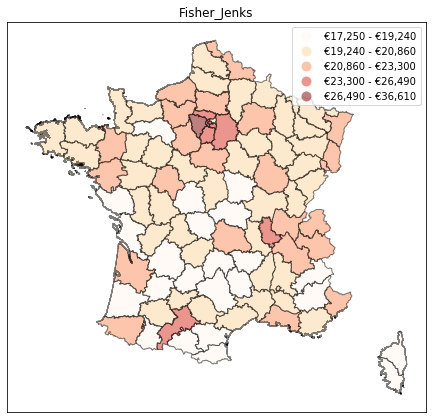

In [204]:
fig, ax = plt.subplots(1, 1, figsize=(7.5, 7.5))
draw_map('all', ax, 'Fisher_Jenks')
ax.set_title('Fisher_Jenks')
plt.show()

## Choosing the number of classes

We now have a sensible way to construct a map with a given number of classes. But what if we want the number of classes itself to be endogenous? A case where this may be handy is when we want to compare the maps obtained for several variables (e.g. the geographical dispersion of wages for professionals and office clerks). If one of them is less homogenous across space, maybe we should represent it with a higher number of classes. In our case, it seems that clerks' wages exhibit less geographical variability over the country. Would it make more sense to use only four classes instead of five for them?

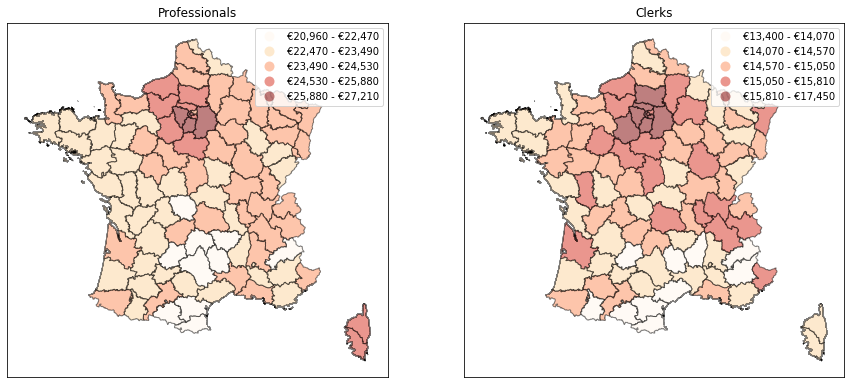

In [136]:
cols = ['professionals', 'clerks']

fig, ax = plt.subplots(1, 2, figsize=(15,15))
for (c, a) in zip(cols, ax):
    draw_map(c, a, 'Fisher_Jenks')
    a.set_title(c.capitalize())
plt.show()


There is a literature on how to pick the optimal number of classes in a clustering problem. However, the issue we face here is a little different: we care less about optimality than about interpretability of the number of classes accross different outcomes. An interesting direction in the context of the Fisher-Jenks method is to fix a given threshold for the share of total variance captured between classes and to find the minimum number of classes needed to reach this threshold, for each map separately.

To get some intuition, we can run the Fisher-Jenks classification for a range of acceptable numbers of classes (2 to 7 in the example below). We can then plot the between-class variance as a function of the number of classes. As it turns out, the between-class variance for clerks is always higher than for professionals which confirms that it might make more sense to use less classes for them. If we want to capture 95% of total variance, only 4 classes are needed for clerks vs. 5 for professionals. With this approach, the maps can also communicate that the wage of clerks is less variable than that of professionals.

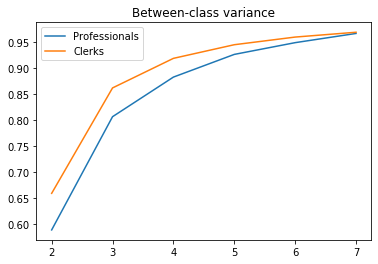

In [146]:
import mapclassify as mc
import numpy as np

def sse(y, yb):
    """Share of variance of y captured bewteen classes yb"""
    
    data = pd.DataFrame({'y':y, 'yb':yb})
    s=data.groupby('yb').agg({'y': ['mean', lambda x: x.var(ddof=0), 'count']})
    s.columns = ['mean', 'var', 'count']
    means = np.average(s.loc[:,'mean'], weights=s.loc[:,'count'])
    var_inter = np.average((s.loc[:,'mean']-means)**2, weights=s.loc[:,'count'])
    var_intra = np.average(s.loc[:,'var'], weights=s.loc[:,'count'])
    return (var_inter / (var_inter+var_intra))

# Between-class variance as a function of the number of classes
ksse = pd.DataFrame()
kvals = list(range(2,8))
for c in cols:
    ksse[c] =np.array([sse(data.loc[:,c], mc.FisherJenks(data.loc[:,c], k=i).yb) for i in kvals])
    plt.plot(kvals, ksse[c])
plt.legend([c.capitalize() for c in cols])
plt.title('Between-class variance')
plt.show()

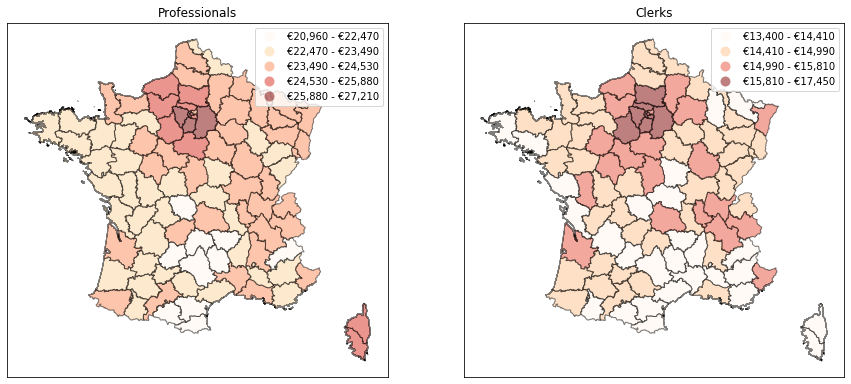

In [138]:
# Number of classes needed to capture 95% of the variance
nclasses = ksse.apply(lambda x: (x>.95).idxmax())

# Maps with computed number of classes
fig, ax = plt.subplots(1, 2, figsize=(15,15))
for (c, a) in zip(cols, ax):
    draw_map(c, a, 'Fisher_Jenks', k=nclasses[c])
    a.set_title(c.capitalize())
plt.show()

## Other metrics?

We looked at the between-class share of total variance as a metric for choosing a number of classes. This is an attractive metric for two reasons. First, we know from the [law of total variance](https://en.wikipedia.org/wiki/Law_of_total_variance) that between-class variance and within-class variance sum nicely to the total variance of the outcome. Second, between-class variance is also the criterion that the Fisher-Jenks method seeks to maximize, so it plays nicely with that method.

Another popular criterion is the between-class share of total absolute deviation from the median. This can be understood as an $L_1$ equivalent of the between-class share of total variance. This criterion will be less sensitive to extreme values, just like the median is with respect to the mean. It is also nicely built into `mapclassify` (where it is known as the goodness of absolute deviation fit or GADF). However, since classes are not built using this criterion, it makes less sense to use this as a threshold in my view. Below is an example.

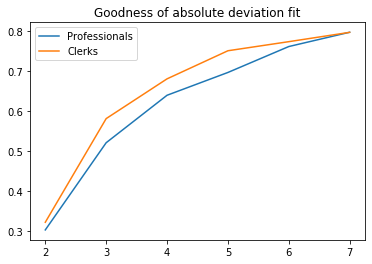

In [185]:
# Plot GADF as a function of the number of classes
gadf = {}
for c in cols:
    gadf[c] =np.array([mc.FisherJenks(data.loc[:,c], k=i).gadf for i in kvals])
    plt.plot(kvals, gadf[c])
plt.legend([c.capitalize() for c in cols])
plt.title('Goodness of absolute deviation fit')
plt.show()

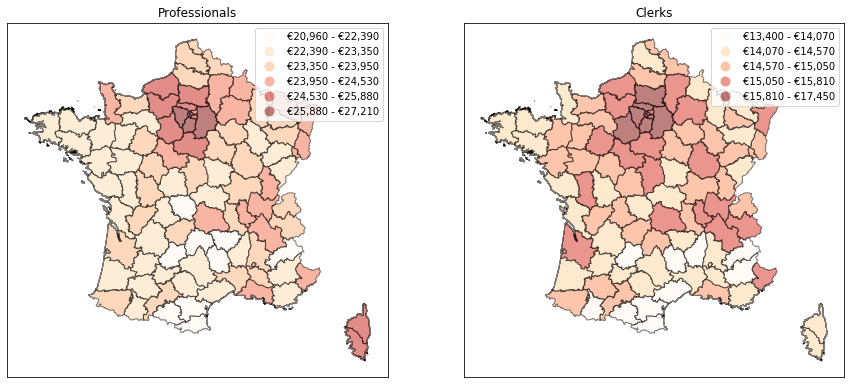

In [200]:
# Number of classes from GADF threshold
fig, ax = plt.subplots(1, 2, figsize=(15,15))
for (c, a) in zip(cols, ax):
    clf = mc.gadf(data.loc[:,c], method='FisherJenks', pct=.7)
    draw_map(c, a, 'Fisher_Jenks', k=clf[0])
    a.set_title(c.capitalize())
plt.show()

## Other clustering methods?

Out of `mapclassify`, I find the Fisher-Jenks method the most convincing. We could however try to go another route by using hierarchical clustering methods from (e.g.) `scipy`. This gives the opportunity to play around with the linkage function, although it is unclear which metric we should follow to assess what linkage function is right. [Ward's method](https://en.wikipedia.org/wiki/Ward%27s_method) seems the most natural since it has a nice interpretation in terms of variance, but then this should just be equivalent to applying the Fisher-Jenks method.

It turns out that hierarchical clustering with Ward's method actually underperforms the Fisher-Jenks approach, which is able to capture a higher share of the variance with less classes (compare the dotted lines with the solid ones in the graph below). This is due to the greedy nature of hierarchical clustering methods. The resulting map for professionnals' wages shows less variation than that obtained with Fisher-Jenks, consistent with the idea that classes are less homogenous.

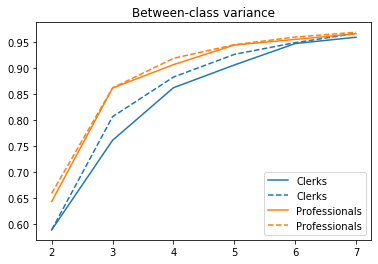

In [162]:
from scipy.cluster import hierarchy as hc

# Between-class variance as a function of the number of classes
ksse_hc = pd.DataFrame()
cuts = {}
for (c, lc) in zip(cols, ['#1f77b4', '#ff7f0e']):
    # Build the linkage matrix
    z = hc.linkage(data.loc[:,[c]], method='ward')
    # Classes for several cut points
    cuts[c] = hc.cut_tree(z, n_clusters=kvals)
    # Compute SSE for each k
    ksse_hc[c] =np.array([sse(data.loc[:,c], cuts[c][:,i]) for i in range(len(kvals))])
    # Plot
    plt.plot(kvals, ksse_hc[c], '-', color=lc)
    plt.plot(kvals, ksse[c], '--', color=lc)
plt.legend(sorted([c.capitalize() for c in cols]*2))
plt.title('Between-class variance')
plt.show()

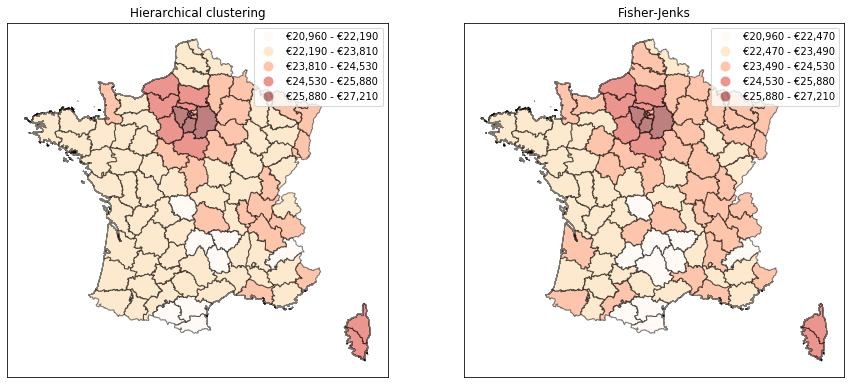

In [163]:
# Number of classes needed to capture 95% of the variance
ksse_hc = pd.DataFrame(ksse_hc)
nclasses_hc = ksse.apply(lambda x: (x>.95).idxmax())

# Maps with computed number of classes
fig, ax = plt.subplots(1, 2, figsize=(15,15))
c = 'professionals'
# Hierarchical clustering
idx = nclasses_hc[c]-kvals[0]
data_classes = pd.DataFrame({'y': data.loc[:,c], 'yb': cuts[c][:,idx]})
bounds = data_classes.groupby('yb').agg('max').values.flatten()
draw_map(c, ax[0], 'UserDefined', classification_kwds={'bins': sorted(bounds)})
ax[0].set_title('Hierarchical clustering')
# Fisher-Jenks
draw_map(c, ax[1], 'Fisher_Jenks', k=nclasses[c])
ax[1].set_title('Fisher-Jenks')

plt.show()